# Evaluation Definition

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence

def evaluate_res_ganomaly(
    netg,
    test_loader,
    *,
    fake_decoder_idx: int,
    bona_label_value: int = 1,
    device: str | torch.device | None = None,
    n_display: int = 3,
    seed: int = 0,
):
    
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)
    netg = netg.to(device).eval()

    # how many decoders?
    if hasattr(netg, "decoders"):
        num_decoders = len(netg.decoders)
    else:
        num_decoders = getattr(netg, "num_generators")

    # containers for metrics and reconstructions
    all_scores, all_best_idxs, all_labels, all_x = [], [], [], []
    all_recons = []  # will hold [D, B, C, H, W] per batch

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            B = x.size(0)
            errs = []
            batch_recons = []

            for j in range(num_decoders):
                x_hat, _, _ = netg.forward_one(x, j)
                # store CPU-side reconstructions for heatmap later
                batch_recons.append(x_hat.cpu())
                # per-sample MSE score for this decoder
                mse = F.mse_loss(x_hat, x, reduction="none")
                errs.append(mse.view(B, -1).mean(dim=1))

            # stack reconstructions: [D, B, C, H, W]
            all_recons.append(torch.stack(batch_recons, dim=0))
            # stack errors: [D, B]
            errs = torch.stack(errs, dim=0)
            best_errs, best_idxs = errs.min(dim=0)

            all_scores.append(best_errs.cpu())
            all_best_idxs.append(best_idxs.cpu())
            all_labels.append(y.cpu())
            all_x.append(x.cpu())

    # concatenate over entire dataset
    scores    = torch.cat(all_scores).numpy()        # [N]
    best_idxs = torch.cat(all_best_idxs).numpy()     # [N]
    labels    = torch.cat(all_labels).numpy()        # [N]
    xs        = torch.cat(all_x).numpy()             # [N, C, H, W]

    bona_mask = labels == bona_label_value
    anom_mask = ~bona_mask

    all_recons = torch.cat(all_recons, dim=1)
    D, N, C, H, W = all_recons.shape
    dist_mat = np.zeros((D, D), dtype=float)

    for i in range(D):
        for j in range(D):
            diff = all_recons[i] - all_recons[j]    # [N, C, H, W]
            dist_mat[i, j] = float((diff**2).mean())

    plt.figure(figsize=(6, 5))
    im = plt.imshow(dist_mat, cmap="viridis", interpolation="nearest")
    plt.title("Heatmap of MSE between Mel-reconstructions\nacross decoders")
    plt.xlabel("Decoder j")
    plt.ylabel("Decoder i")
    plt.colorbar(im, label="Mean Squared Error")
    plt.xticks(np.arange(D))
    plt.yticks(np.arange(D))
    plt.show()

    # 2) Zoomed histogram [1–80 percentile]
    lo, hi = np.percentile(scores, [1, 95])
    plt.figure()
    plt.hist(scores[bona_mask], bins=100, alpha=0.6,
             label="Bona-fide", range=(lo, hi))
    plt.hist(scores[anom_mask], bins=100, alpha=0.6,
             label="Anomalous", range=(lo, hi))
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.title("Scores zoomed to 1–80 percentile")
    plt.legend()
    plt.show()

    # 3) Decoder selection frequency
    counts = np.bincount(best_idxs, minlength=num_decoders)
    plt.figure()
    plt.bar(np.arange(num_decoders), counts)
    plt.xlabel("Decoder index")
    plt.ylabel("Selections")
    plt.title("Decoder selection frequency")
    plt.show()

    # 4) Show sample reconstructions in 4×2 grids with suptitle
    rng = np.random.default_rng(seed)
    bona_idxs = rng.choice(np.where(bona_mask)[0],
                           size=min(n_display, bona_mask.sum()),
                           replace=False)
    anom_idxs = rng.choice(np.where(anom_mask)[0],
                           size=min(n_display, anom_mask.sum()),
                           replace=False)

    def _plot_grid(arrs: Sequence[np.ndarray],
                   titles: Sequence[str],
                   suptitle: str):
        rows, cols = 4, 2
        cell = 3  # inches per cell
        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*cell, rows*cell),
            constrained_layout=True
        )
        if suptitle:
            fig.suptitle(suptitle, fontsize=14)
        axes = axes.flatten()
        for ax in axes[len(arrs):]:
            ax.axis("off")
        for i, (spec, title) in enumerate(zip(arrs, titles)):
            ax = axes[i]
            ax.imshow(spec, origin="lower", interpolation="nearest")
            ax.set_title(title, fontsize=9)
            ax.set_aspect("equal", adjustable="box")
            ax.axis("off")
        plt.show()
        print()

    # bona-fide examples
    for idx in bona_idxs:
        arrs, titles = [], []
        inp = xs[idx]  # (C, H, W)
        arrs.append(inp[0]); titles.append("Input")
        x0 = torch.from_numpy(inp).unsqueeze(0).to(device)
        with torch.no_grad():
            for j in range(num_decoders):
                x_hat, _, _ = netg.forward_one(x0, j)
                arrs.append(x_hat.cpu().numpy()[0, 0])
                titles.append(f"Decoder {j}")
        _plot_grid(arrs, titles, suptitle=f"Bona-fide sample idx={idx}")

    # anomalous examples
    for idx in anom_idxs:
        arrs, titles = [], []
        inp = xs[idx]
        arrs.append(inp[0]); titles.append("Input")
        x0 = torch.from_numpy(inp).unsqueeze(0).to(device)
        with torch.no_grad():
            for j in range(num_decoders):
                x_hat, _, _ = netg.forward_one(x0, j)
                arrs.append(x_hat.cpu().numpy()[0, 0])
                titles.append(f"Decoder {j}")
        _plot_grid(arrs, titles, suptitle=f"Anomalous sample idx={idx}")

    return scores, best_idxs, labels


In [4]:
import os, numpy as np, torch
from torch.utils.data import Dataset, DataLoader

class AggregatedPairDataset(Dataset):

    def __init__(self, dir_path: str, *, isize: int = 64):
        self.samples = []
        for fname, lbl in (('fake.npy', 1), ('real.npy', 0)):
            p = os.path.join(dir_path, fname)
            arr = np.load(p).astype('float32')          # (N,1,H,W)
            if arr.ndim != 4 or arr.shape[2:] != (isize, isize):
                raise ValueError(
                    f"{fname}: expected (N,1,{isize},{isize}), got {arr.shape}"
                )
            # Push each item with its class label
            for spec in arr:
                self.samples.append((spec, lbl))
        # shuffle once so classes are mixed (keep deterministic if needed)
        np.random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        spec, lbl = self.samples[idx]
        return torch.from_numpy(spec), torch.tensor(lbl, dtype=torch.long)

In [5]:
%cd ..
%pwd

/home/ml/Documents/voice/Res_GANomaly/ganomaly


/home/ml/Documents/myenv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/ml/Documents/voice/Res_GANomaly/ganomaly'

# Train: Wavefake64, Eval: Wavefake64

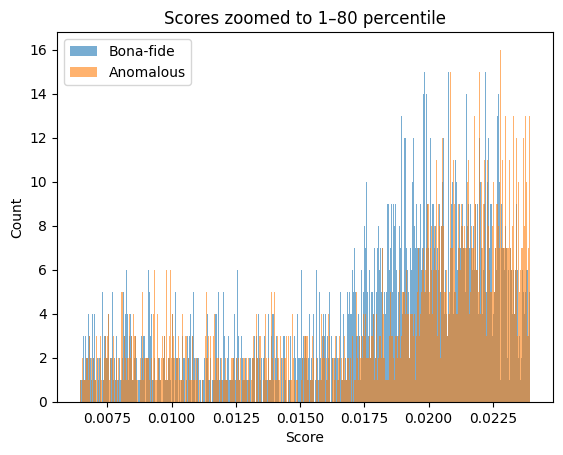

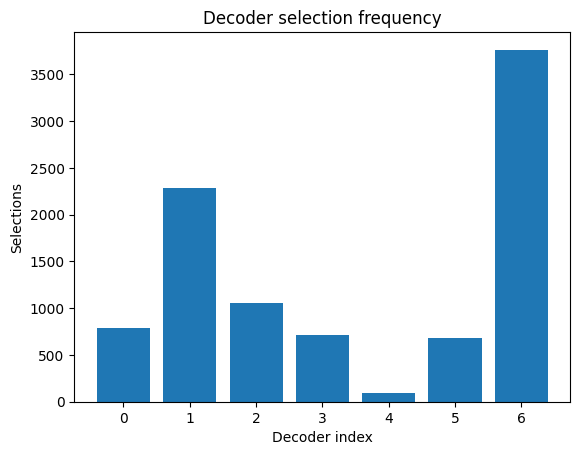

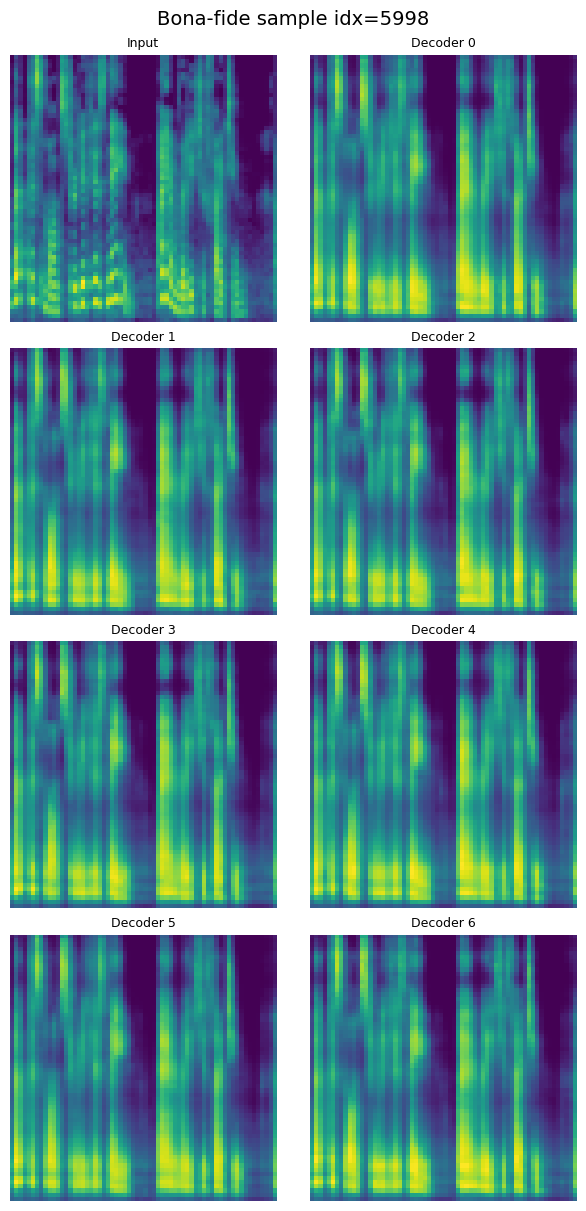

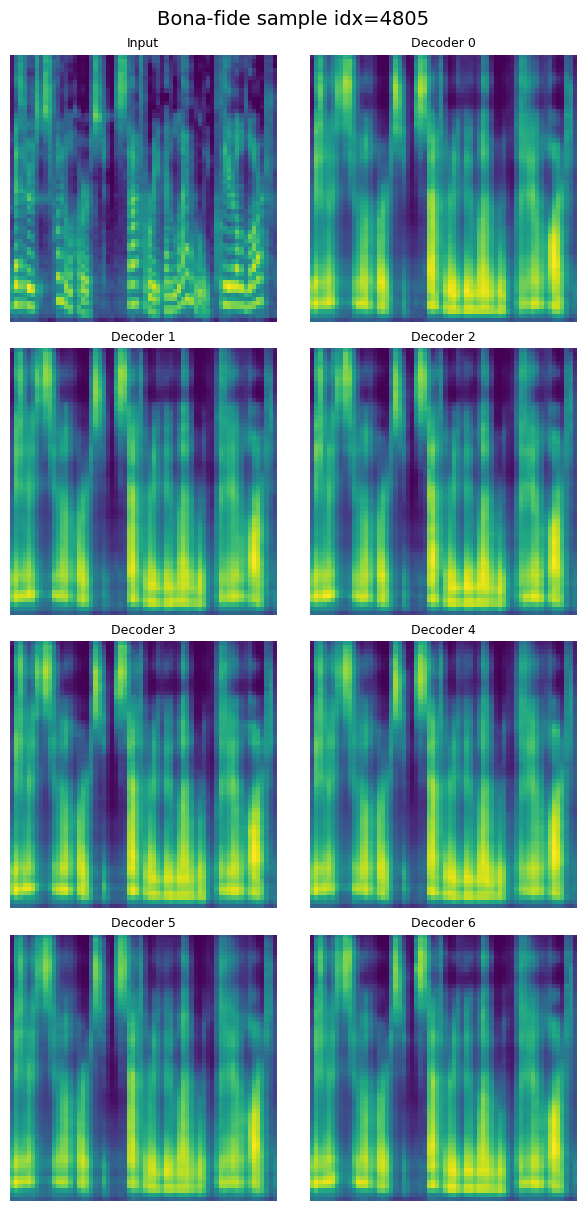

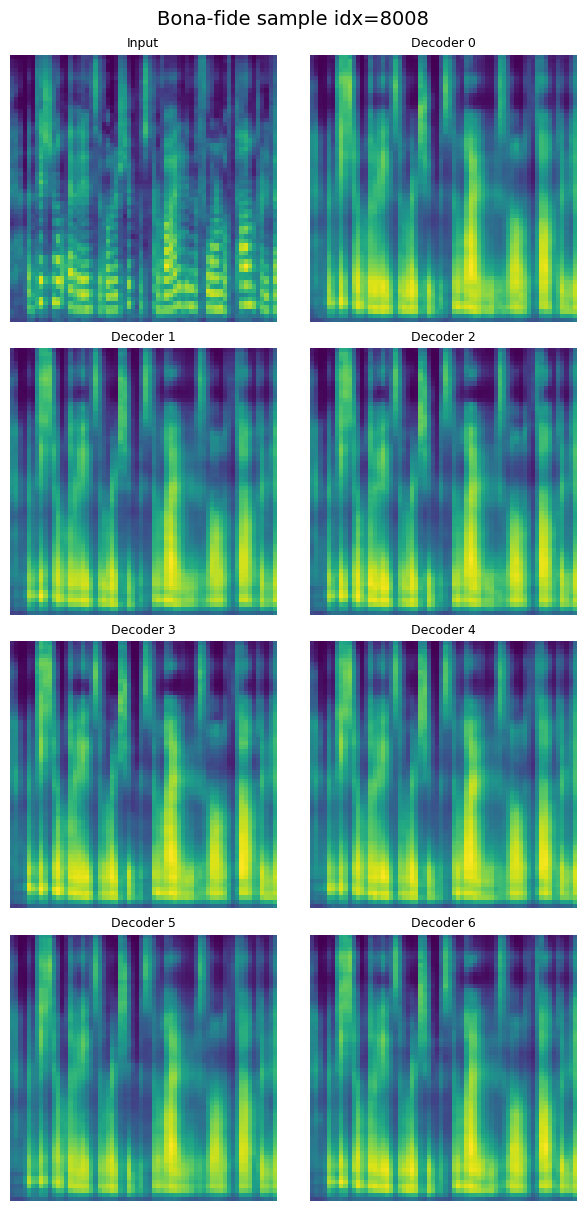

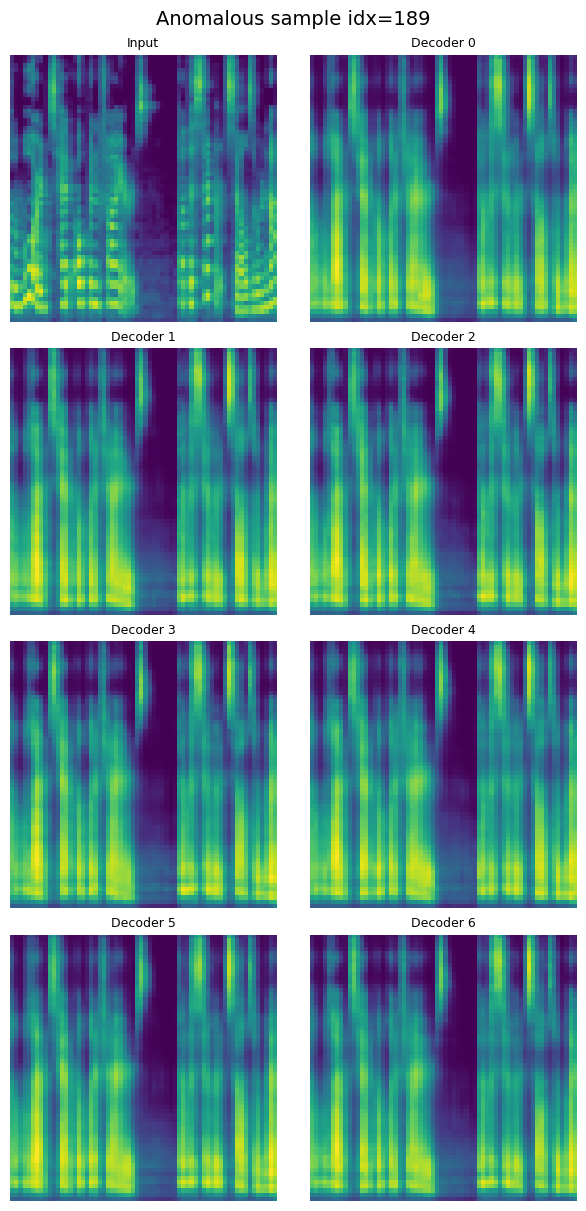

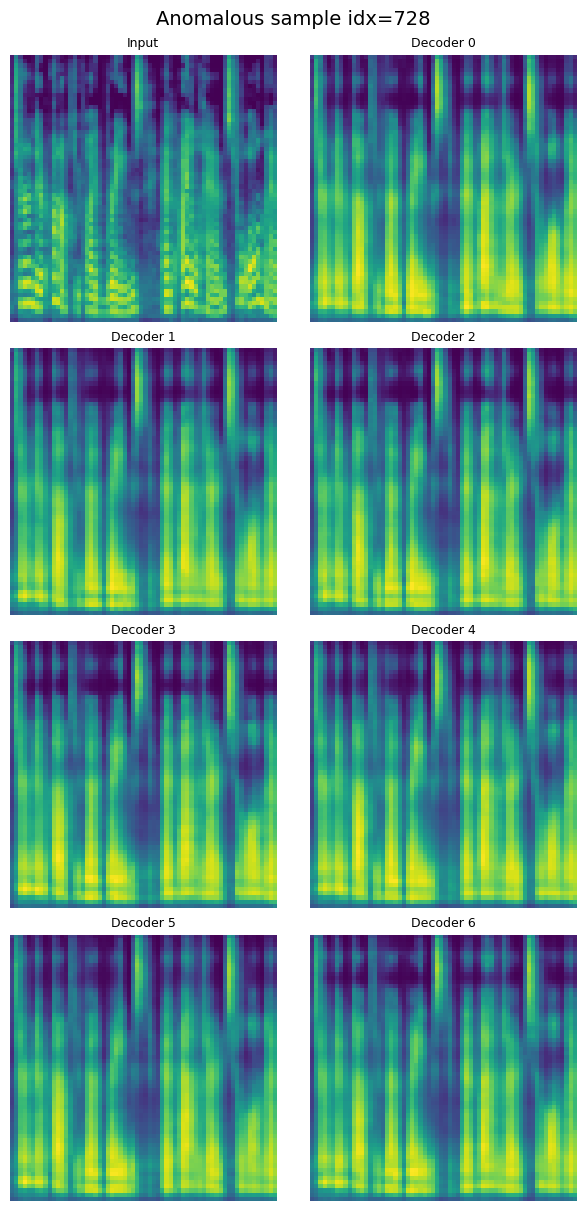

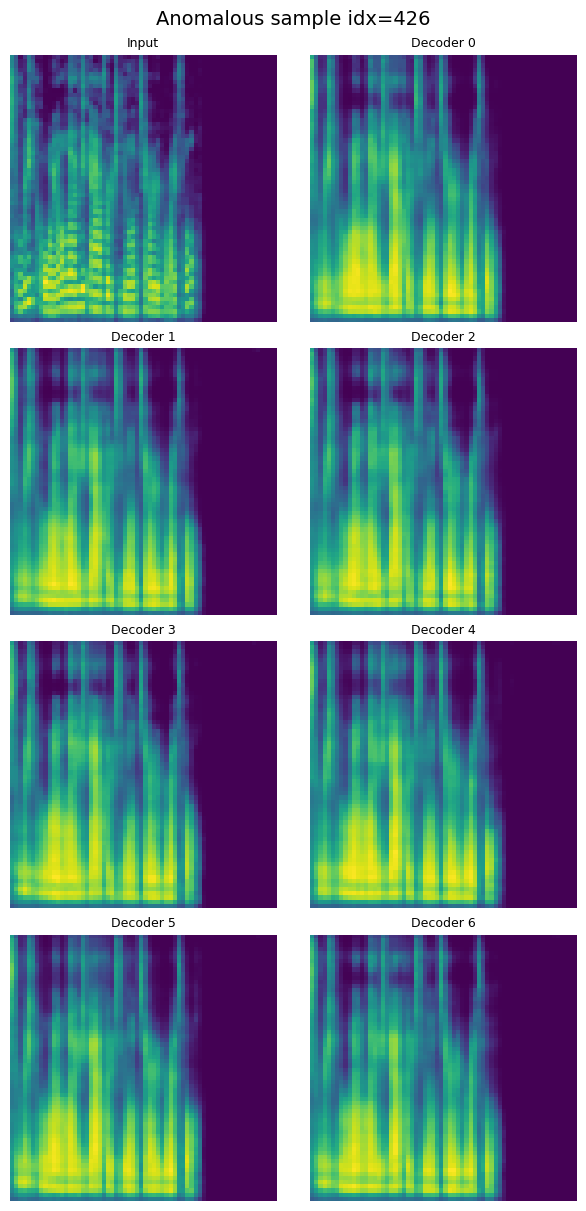

In [10]:
from types import SimpleNamespace

opt = SimpleNamespace(
    # — model dimensions —
    isize          = 64,     # H == W of your spectrogram tiles
    nc             = 1,      # input channels
    nz             = 100,    # latent vector dim
    ngf            = 64,     # generator base feat-maps
    ndf            = 128,    # discriminator base feat-maps
    num_generators = 7,      # ← number of decoders you trained

    # — runtime / device —
    device = "cuda:0",       # "cpu" or "cuda:0" / "cuda:1" …
    ngpu   = 1,              # only needed if NetG/NetD look at it

    batchsize  = 64,
    lr         = 1e-4,
    beta1      = 0.5,
    niter      = 3_000,
    w_adv      = 1.0,
    w_con      = 50.0,
    w_enc      = 1.0,
    lambda_gp  = 1.0,
    n_critic   = 5,
    tb_freq    = 10,
    metric     = "roc",
    manualseed = -1,

    outf        = "./output_multigan",
    name        = "FirstTime64",
    netg_ckpt   = None,
    netd_ckpt   = None,
)

from lib.Resnetworks import NetG_Multi_RES_GANomaly as NetG
import torch

# (a) build & load generator
netg = NetG(opt)
ckpt  = torch.load('/home/ml/Documents/voice/output_multigan/FirstTime64/checkpoints/checkpoint_epoch330.pth', map_location='cpu')
netg.load_state_dict(ckpt['netG'], strict=False)

# (b) DataLoader for the aggregated test folder
test_folder = '/home/ml/Documents/voice/ResData/wavefake64_split/test/aggregated'  
test_ds     = AggregatedPairDataset(test_folder, isize=opt.isize)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# (c) run evaluation/visualisation (function from previous cell)
scores, best_idxs, labels = evaluate_res_ganomaly(
    netg,
    test_loader,
    fake_decoder_idx = 1,     # bona-fide decoder index
    bona_label_value = 1,     # label 1 = bona-fide (fake)
    device           = 'cuda',
    n_display        = 3
)

# Train: Wavefake32, Eval: Wavefake32

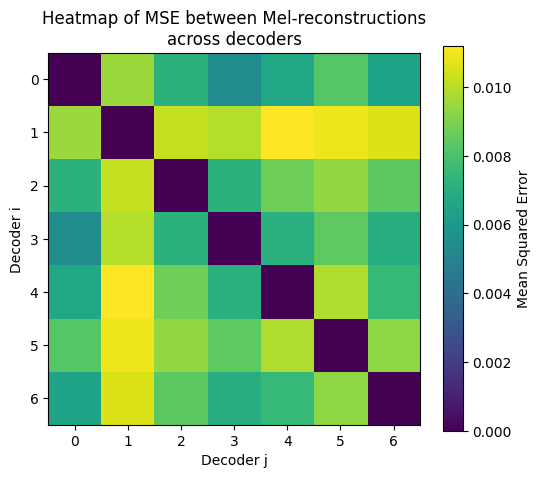

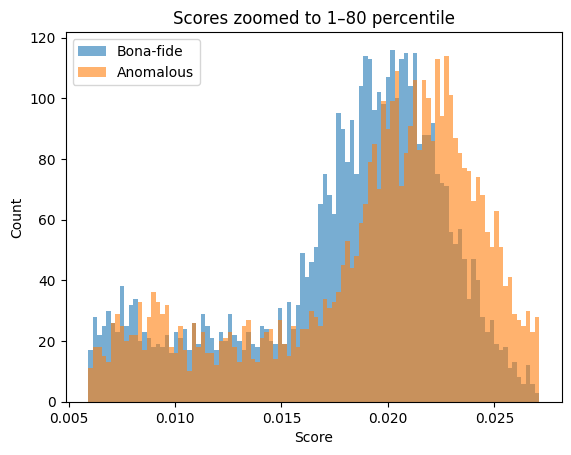

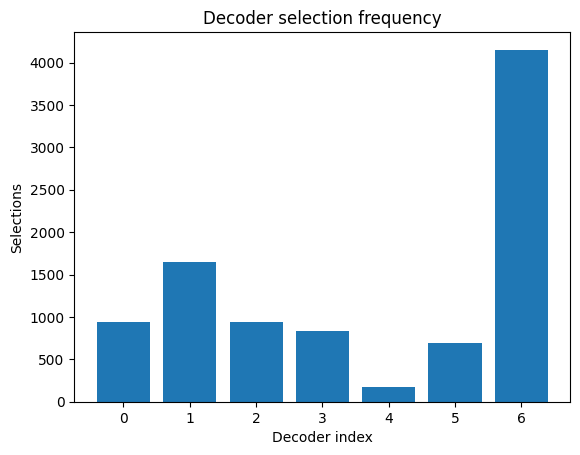

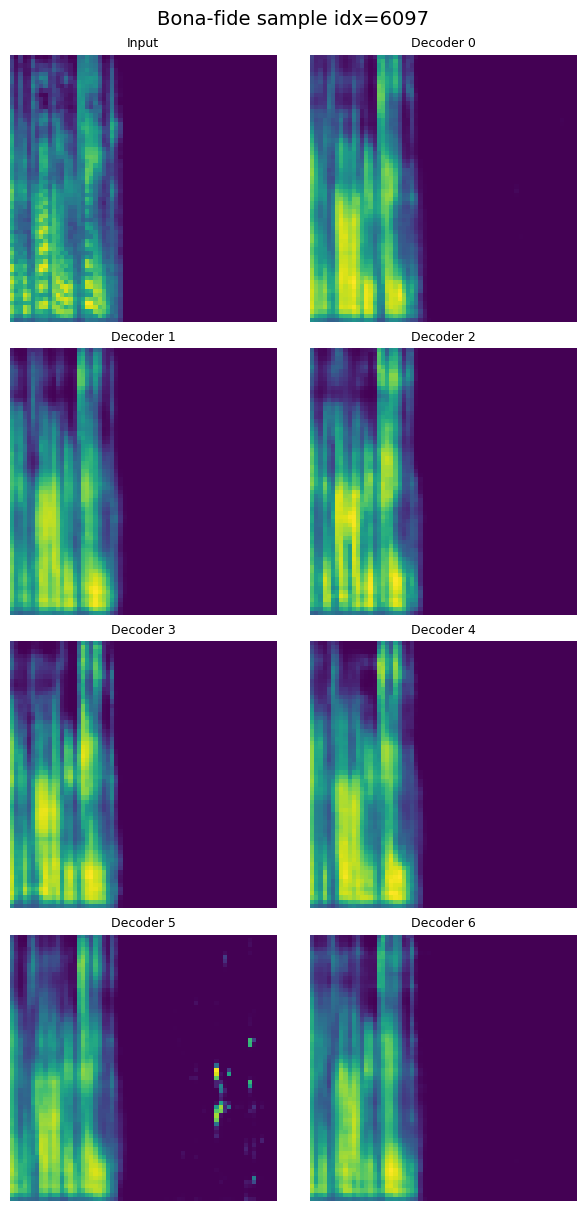

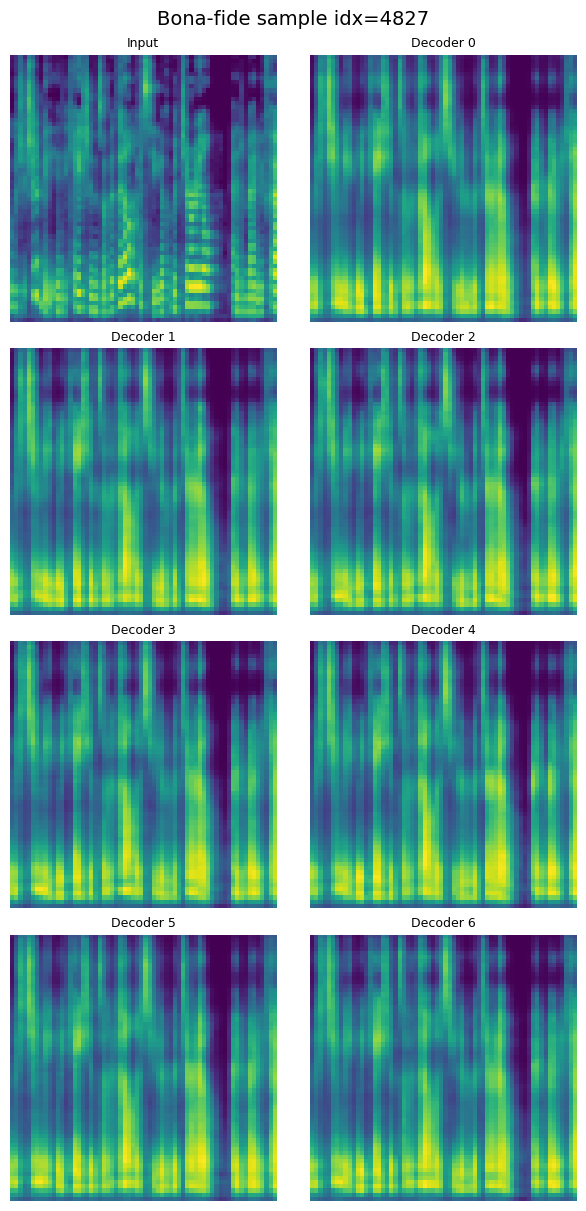

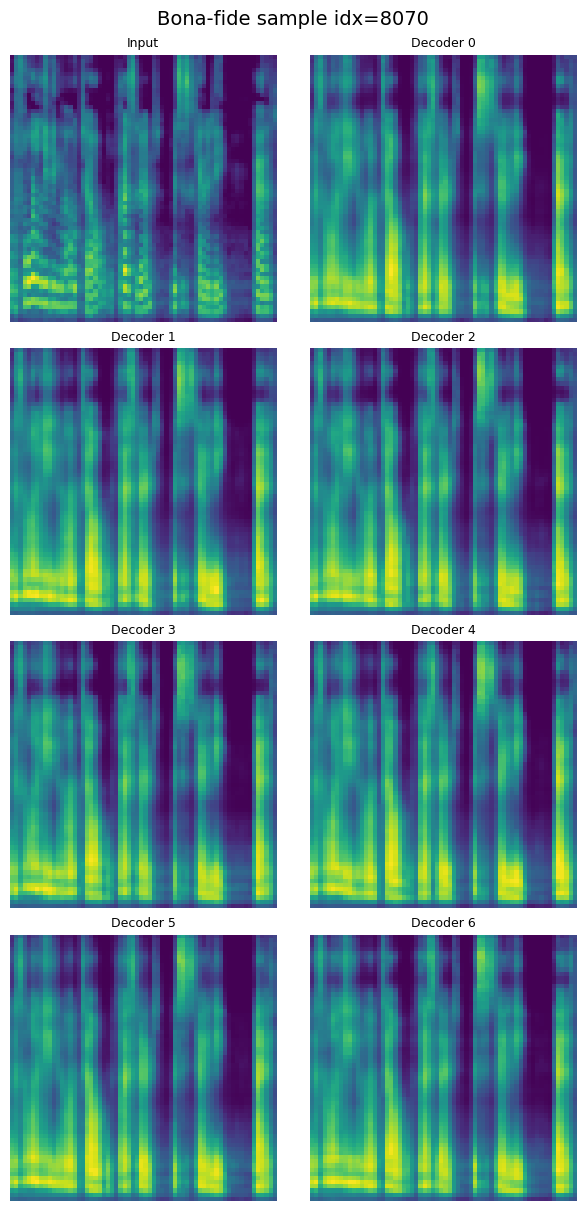

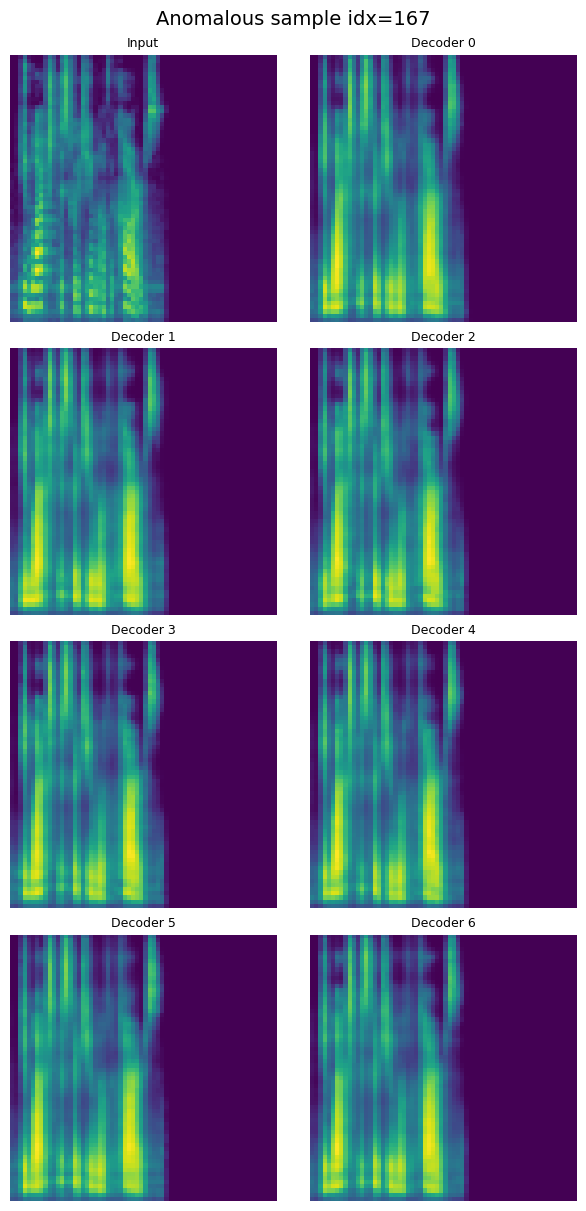

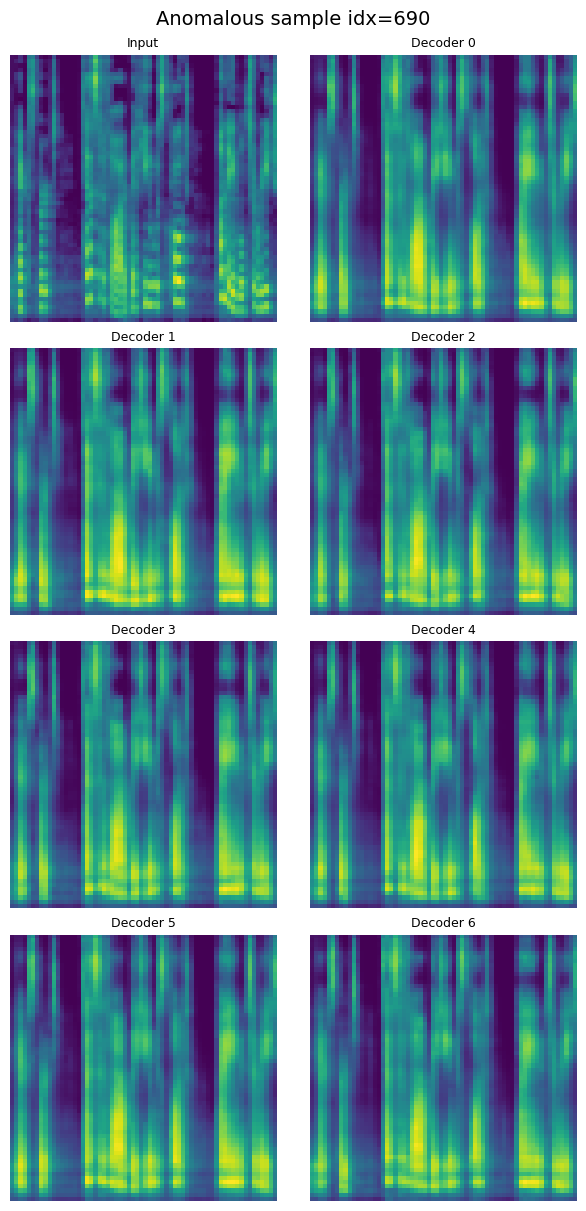

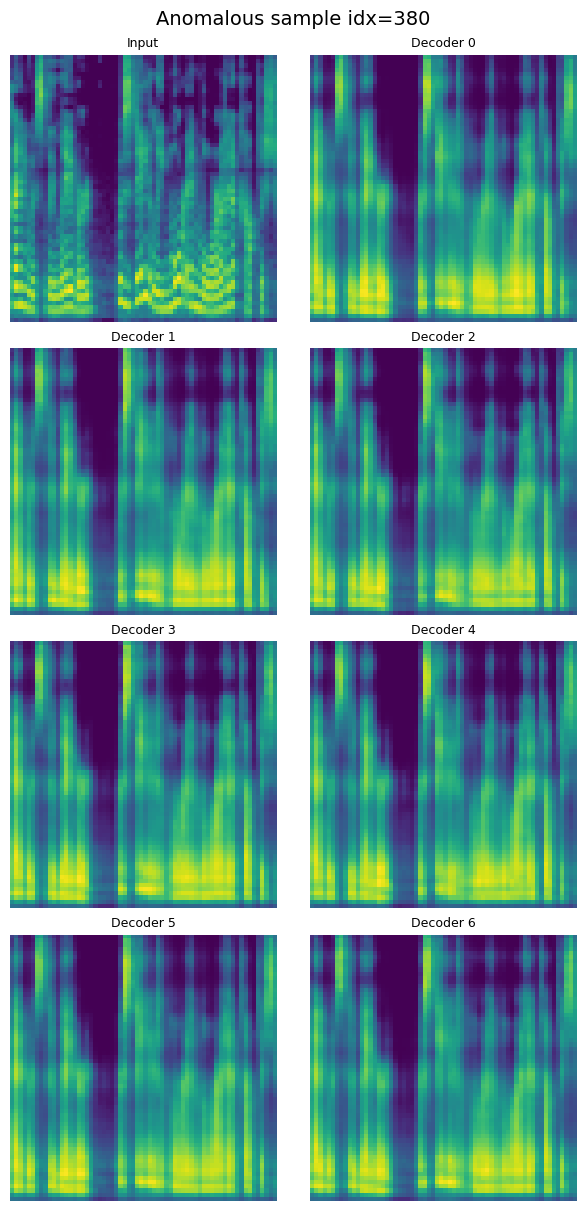

In [6]:
from types import SimpleNamespace

opt = SimpleNamespace(
    # — model dimensions —
    isize          = 64,     # H == W of your spectrogram tiles
    nc             = 1,      # input channels
    nz             = 100,    # latent vector dim
    ngf            = 64,     # generator base feat-maps
    ndf            = 128,    # discriminator base feat-maps
    num_generators = 7,      # ← number of decoders you trained

    # — runtime / device —
    device = "cuda:0",       # "cpu" or "cuda:0" / "cuda:1" …
    ngpu   = 1,              # only needed if NetG/NetD look at it

    batchsize  = 64,
    lr         = 1e-4,
    beta1      = 0.5,
    niter      = 3_000,
    w_adv      = 1.0,
    w_con      = 50.0,
    w_enc      = 1.0,
    lambda_gp  = 1.0,
    n_critic   = 5,
    tb_freq    = 10,
    metric     = "roc",
    manualseed = -1,

    outf        = "./output_multigan",
    name        = "FirstTime64",
    netg_ckpt   = None,
    netd_ckpt   = None,
)

from lib.Resnetworks import NetG_Multi_RES_GANomaly as NetG
import torch

# (a) build & load generator
netg = NetG(opt)
ckpt  = torch.load('/home/ml/Documents/voice/output_multigan/FirstTime64/checkpoints/checkpoint_epoch1360.pth', map_location='cpu')
netg.load_state_dict(ckpt['netG'], strict=False)

# (b) DataLoader for the aggregated test folder
test_folder = '/home/ml/Documents/voice/ResData/wavefake64_split/test/aggregated'  
test_ds     = AggregatedPairDataset(test_folder, isize=opt.isize)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# (c) run evaluation/visualisation (function from previous cell)
scores, best_idxs, labels = evaluate_res_ganomaly(
    netg,
    test_loader,
    fake_decoder_idx = 1,     # bona-fide decoder index
    bona_label_value = 1,     # label 1 = bona-fide (fake)
    device           = 'cuda',
    n_display        = 3
)

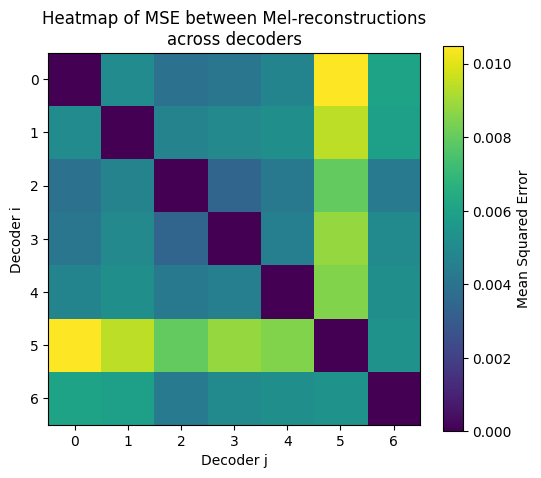

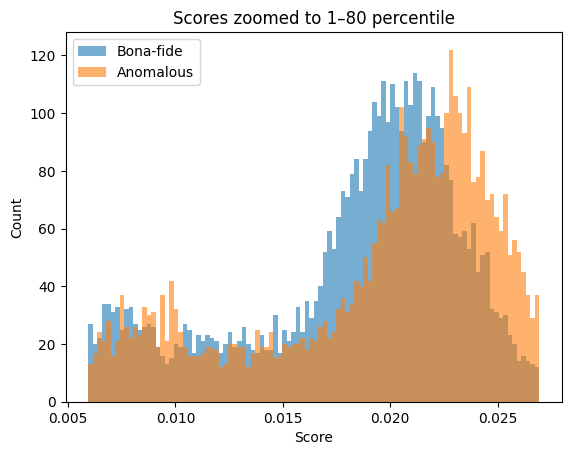

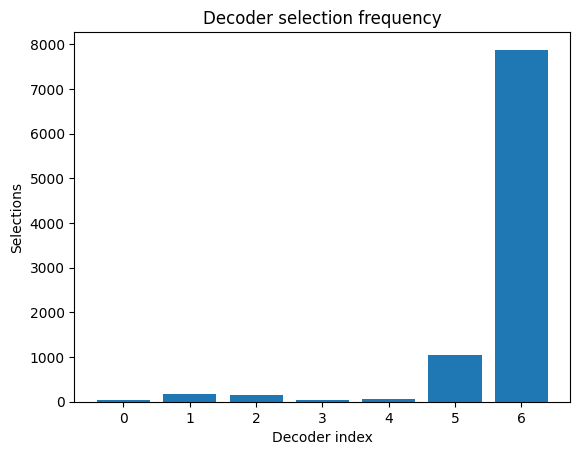

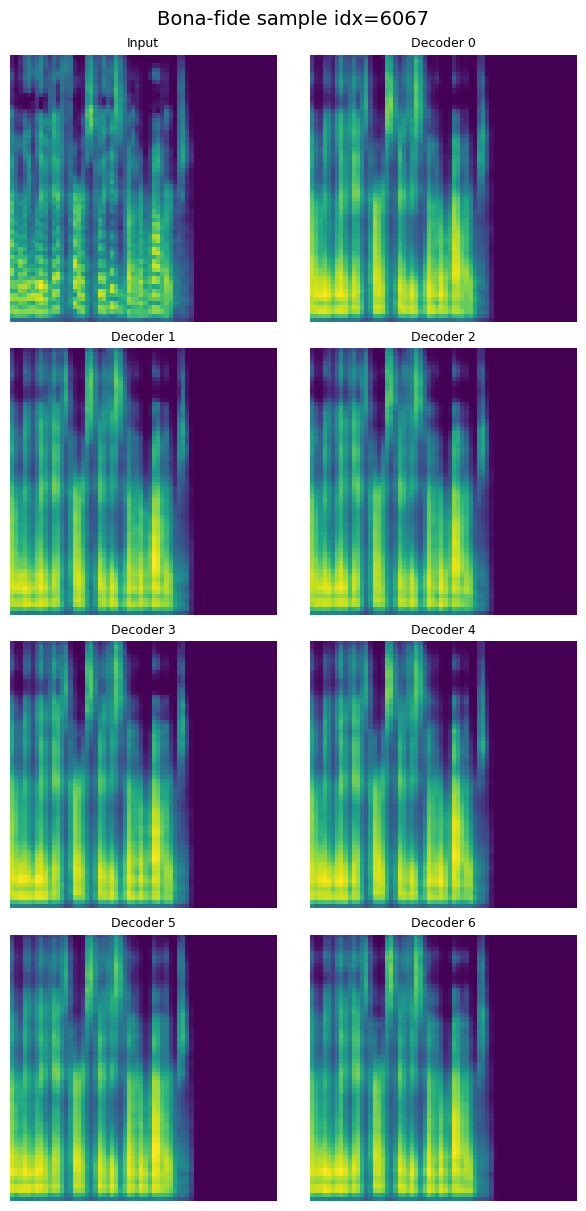

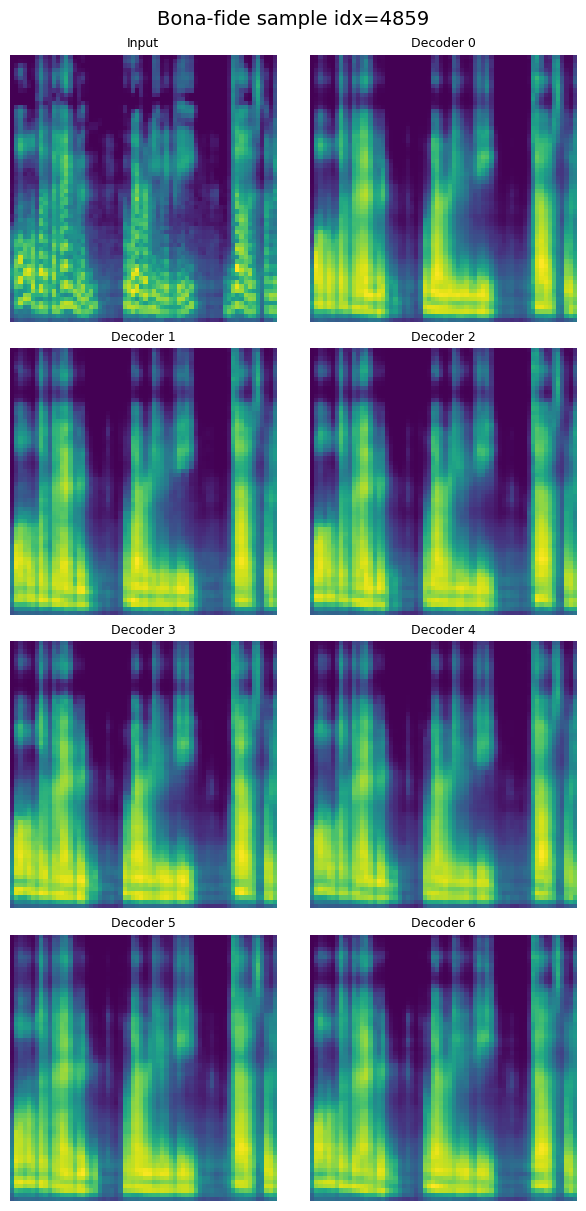

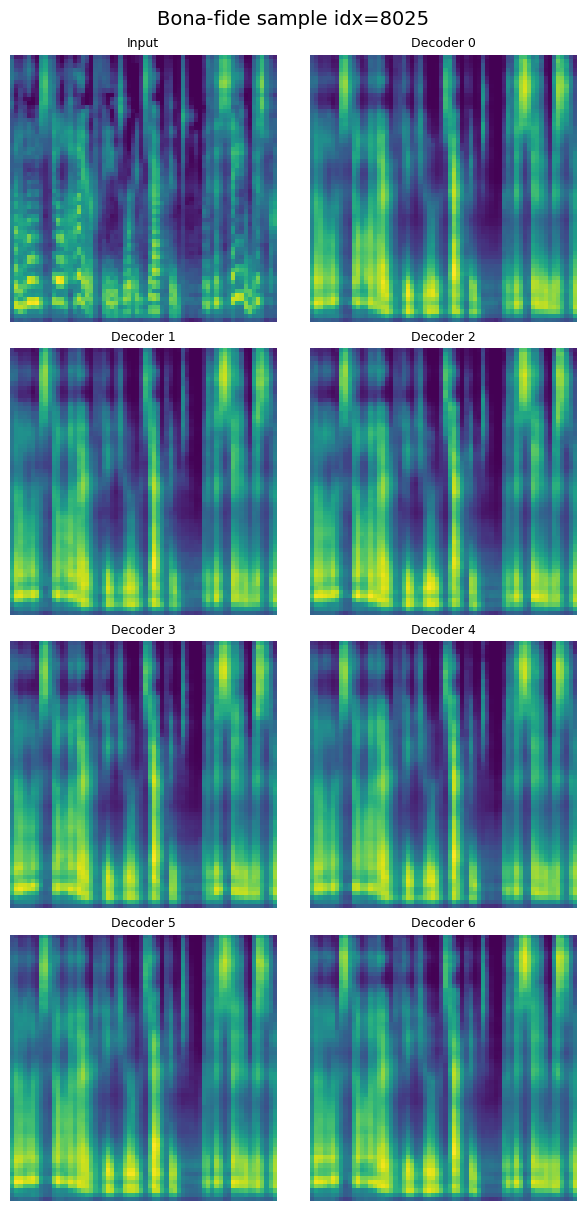

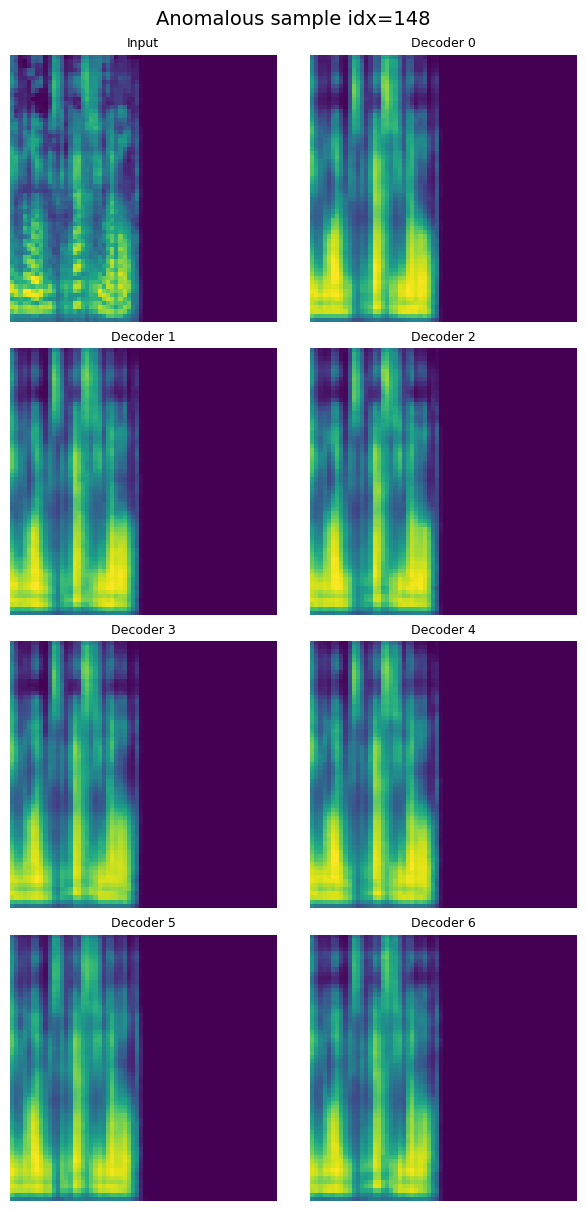

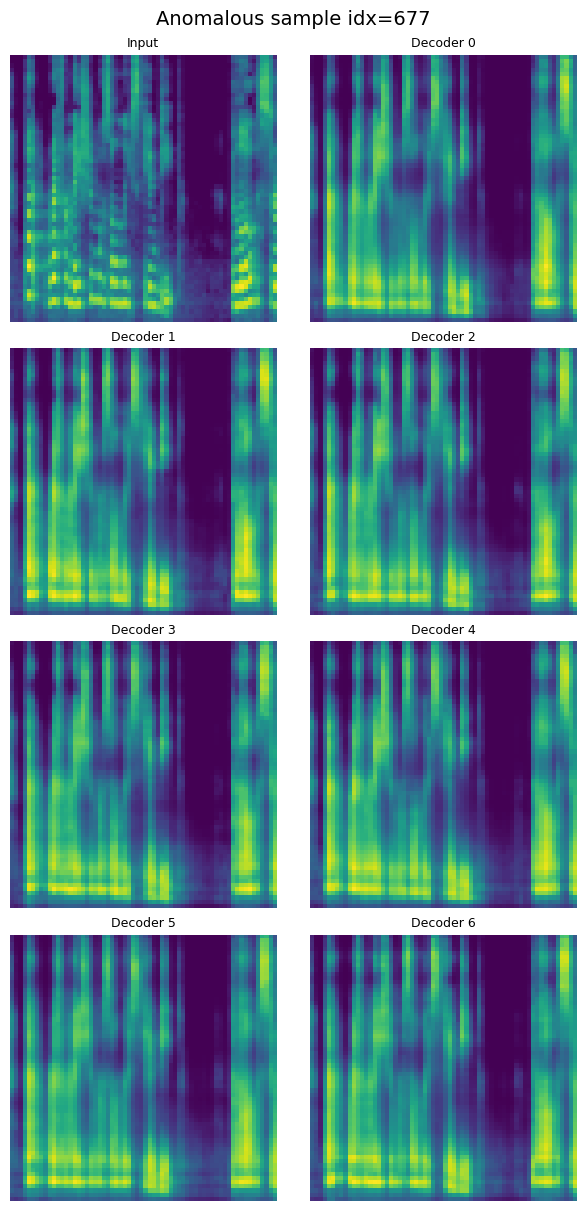

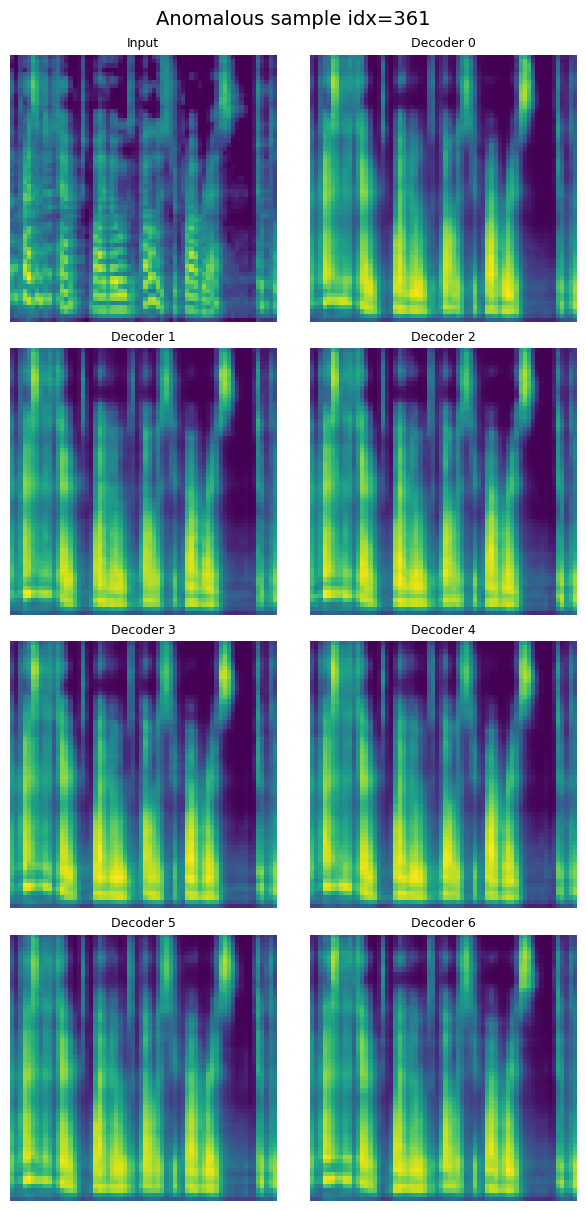

In [7]:
from types import SimpleNamespace

opt = SimpleNamespace(
    # — model dimensions —
    isize          = 64,     # H == W of your spectrogram tiles
    nc             = 1,      # input channels
    nz             = 100,    # latent vector dim
    ngf            = 64,     # generator base feat-maps
    ndf            = 128,    # discriminator base feat-maps
    num_generators = 7,      # ← number of decoders you trained

    # — runtime / device —
    device = "cuda:0",       # "cpu" or "cuda:0" / "cuda:1" …
    ngpu   = 1,              # only needed if NetG/NetD look at it

    batchsize  = 64,
    lr         = 1e-4,
    beta1      = 0.5,
    niter      = 3_000,
    w_adv      = 1.0,
    w_con      = 50.0,
    w_enc      = 1.0,
    lambda_gp  = 1.0,
    n_critic   = 5,
    tb_freq    = 10,
    metric     = "roc",
    manualseed = -1,

    outf        = "./output_multigan",
    name        = "FirstTime64",
    netg_ckpt   = None,
    netd_ckpt   = None,
)

from lib.Resnetworks import NetG_Multi_RES_GANomaly as NetG
import torch

# (a) build & load generator
netg = NetG(opt)
ckpt  = torch.load('/home/ml/Documents/voice/output_multigan/FirstTime64/checkpoints/checkpoint_epoch670.pth', map_location='cpu')
netg.load_state_dict(ckpt['netG'], strict=False)

# (b) DataLoader for the aggregated test folder
test_folder = '/home/ml/Documents/voice/ResData/wavefake64_split/test/aggregated'  
test_ds     = AggregatedPairDataset(test_folder, isize=opt.isize)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# (c) run evaluation/visualisation (function from previous cell)
scores, best_idxs, labels = evaluate_res_ganomaly(
    netg,
    test_loader,
    fake_decoder_idx = 1,     # bona-fide decoder index
    bona_label_value = 1,     # label 1 = bona-fide (fake)
    device           = 'cuda',
    n_display        = 3
)

# Train: Wavefake128, Eval: Wavefake128

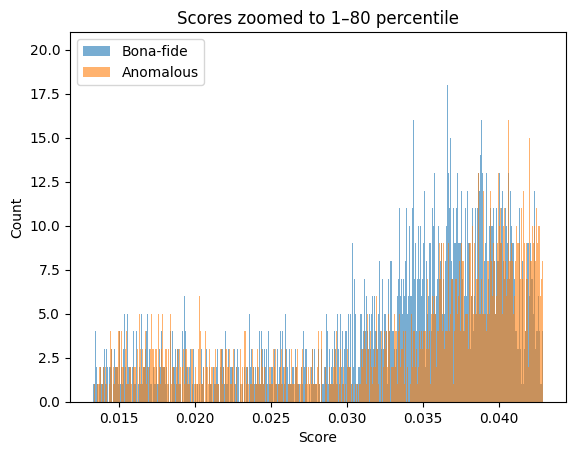

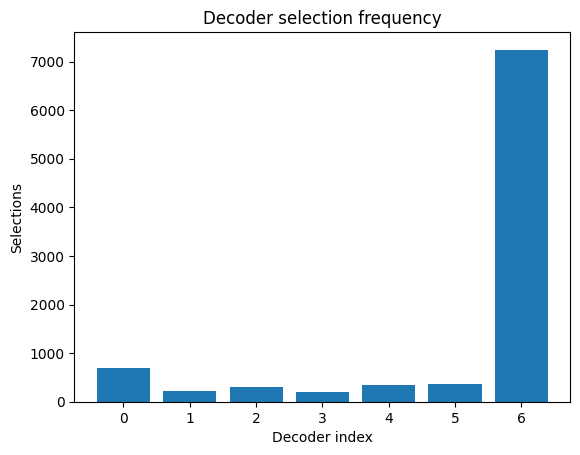

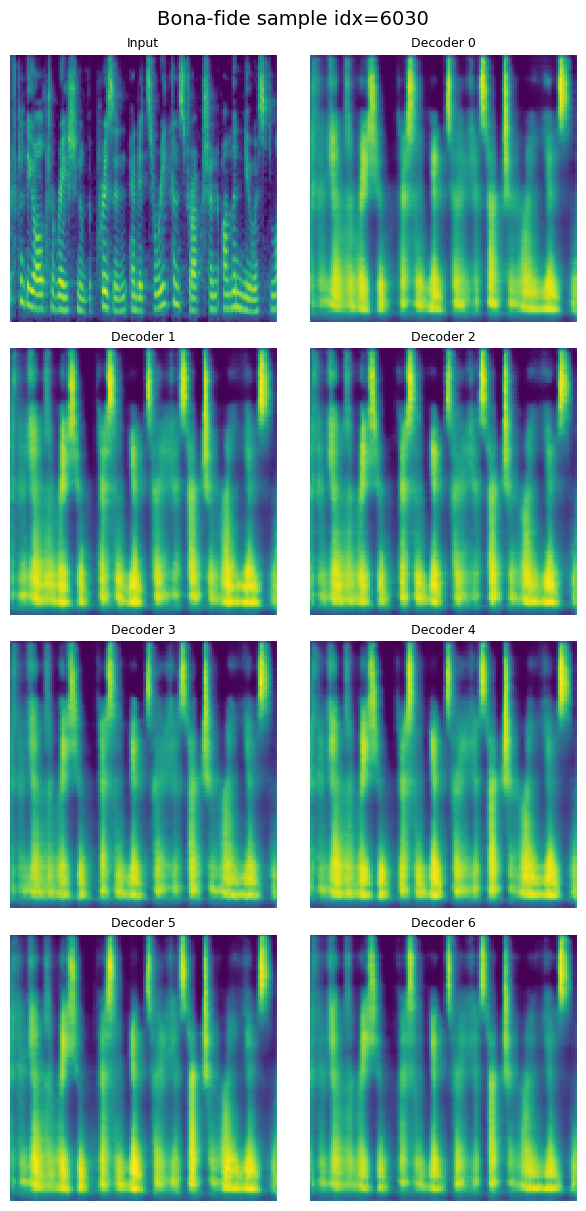

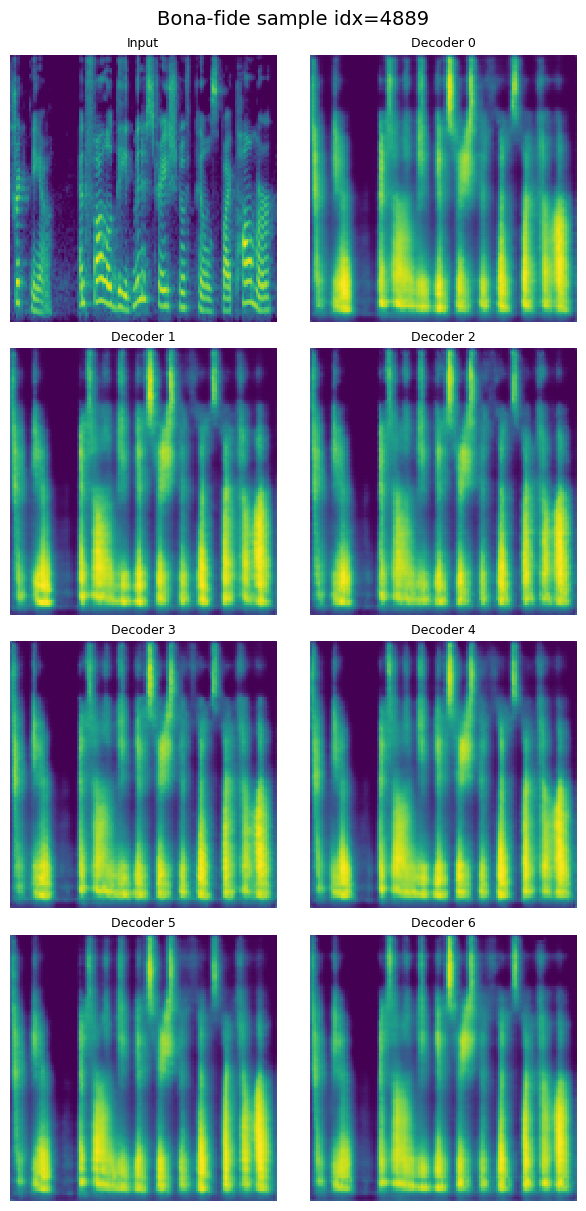

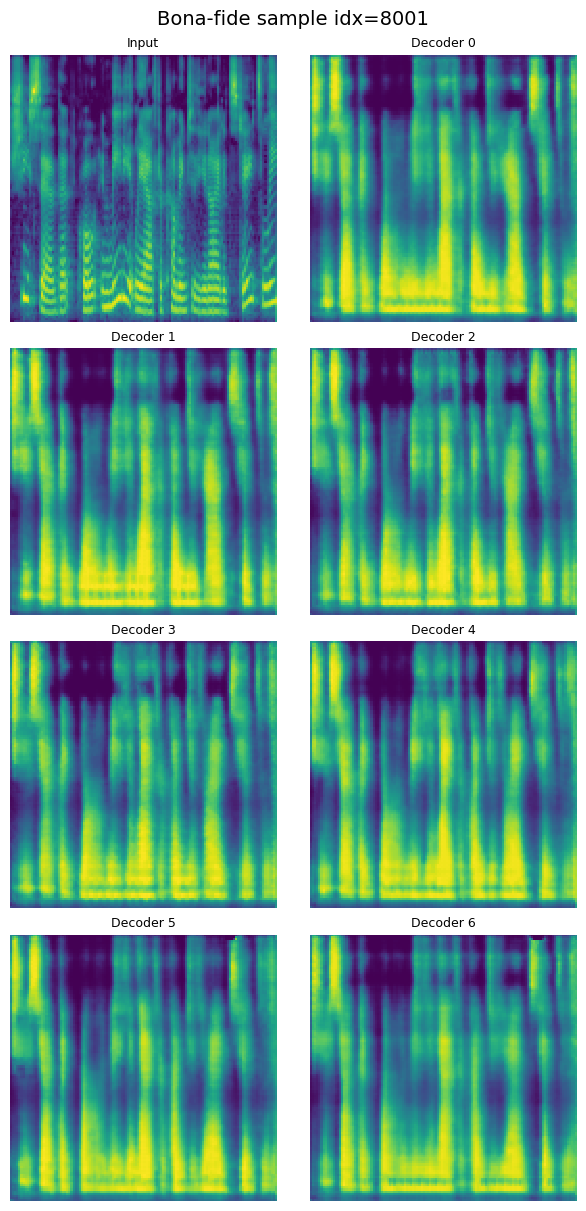

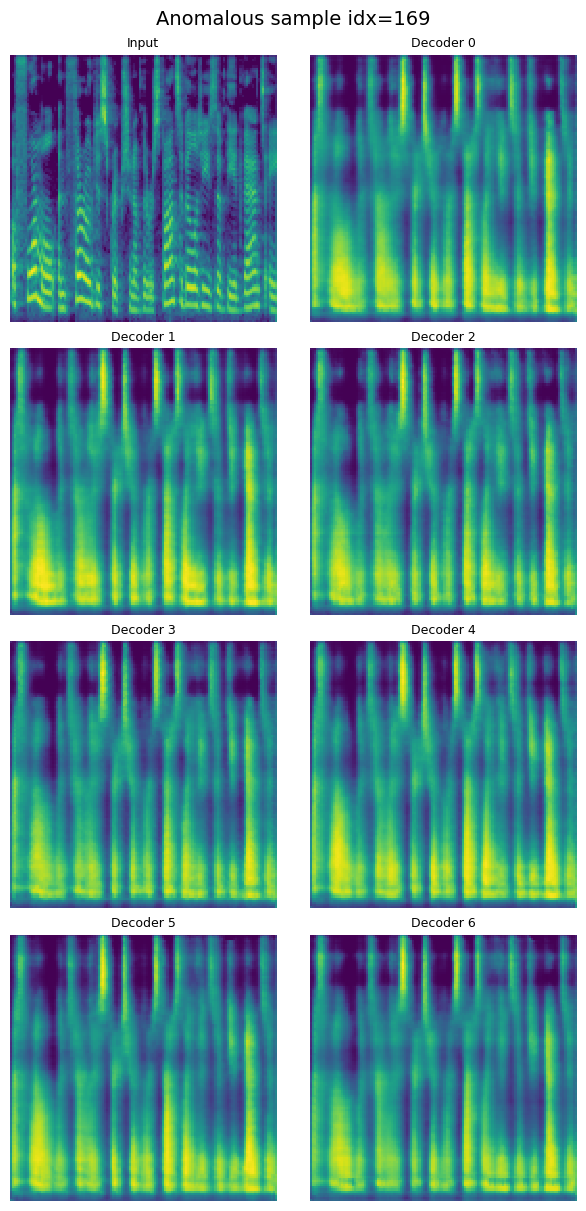

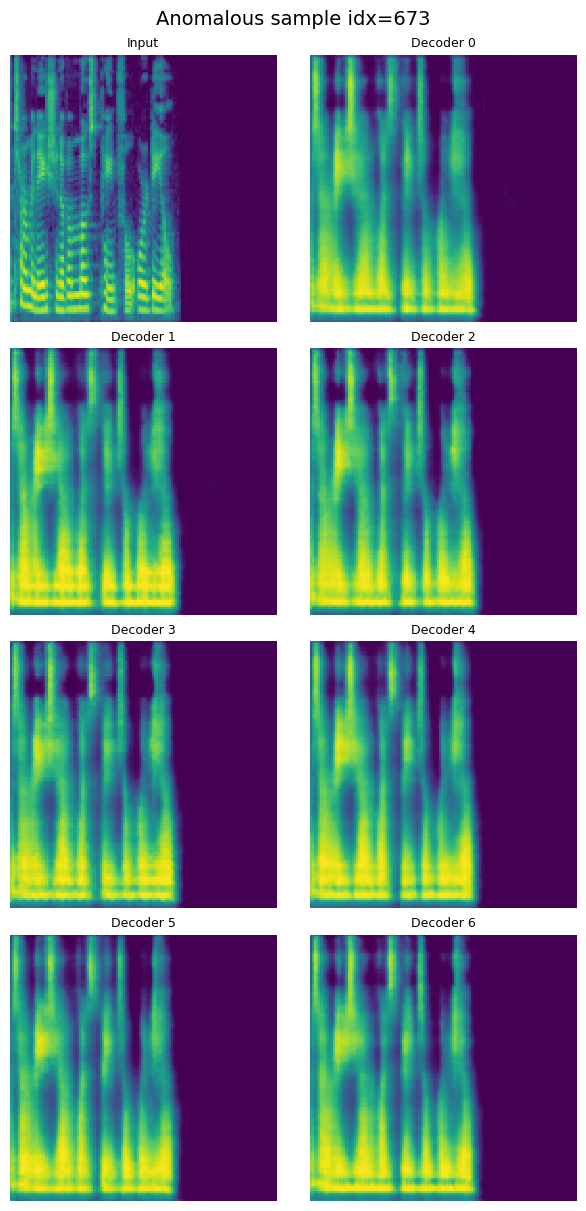

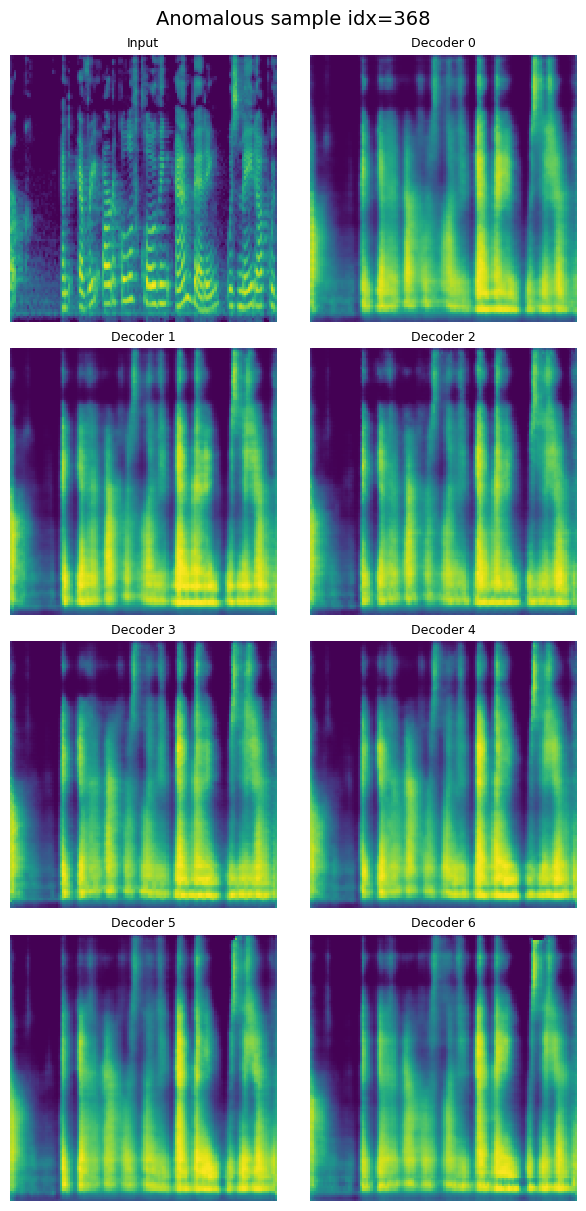

In [15]:
from types import SimpleNamespace

opt = SimpleNamespace(
    # — model dimensions —
    isize          = 128,     # H == W of your spectrogram tiles
    nc             = 1,      # input channels
    nz             = 100,    # latent vector dim
    ngf            = 64,     # generator base feat-maps
    ndf            = 128,    # discriminator base feat-maps
    num_generators = 7,      # ← number of decoders you trained

    # — runtime / device —
    device = "cuda:0",       # "cpu" or "cuda:0" / "cuda:1" …
    ngpu   = 1,              # only needed if NetG/NetD look at it

    batchsize  = 64,
    lr         = 1e-4,
    beta1      = 0.5,
    niter      = 3_000,
    w_adv      = 1.0,
    w_con      = 50.0,
    w_enc      = 1.0,
    lambda_gp  = 1.0,
    n_critic   = 5,
    tb_freq    = 10,
    metric     = "roc",
    manualseed = -1,

    outf        = "./output_multigan",
    name        = "FirstTime64",
    netg_ckpt   = None,
    netd_ckpt   = None,
)

from lib.Resnetworks import NetG_Multi_RES_GANomaly as NetG
import torch

# (a) build & load generator
netg = NetG(opt)
ckpt  = torch.load('/home/ml/Documents/voice/output_multigan/FirstTime128/checkpoints/checkpoint_epoch60.pth', map_location='cpu')
netg.load_state_dict(ckpt['netG'], strict=False)

# (b) DataLoader for the aggregated test folder
test_folder = '/home/ml/Documents/voice/ResData/wavefake128_split/test/aggregated'  
test_ds     = AggregatedPairDataset(test_folder, isize=opt.isize)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# (c) run evaluation/visualisation (function from previous cell)
scores, best_idxs, labels = evaluate_res_ganomaly(
    netg,
    test_loader,
    fake_decoder_idx = 1,     # bona-fide decoder index
    bona_label_value = 1,     # label 1 = bona-fide (fake)
    device           = 'cuda',
    n_display        = 3
)